In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from post_processing import *
from utils import *
from fast_macro_f1_func import *
from viterbi_utils import *

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
df_train = pd.read_pickle('../features/train_clean.pkl')
df_test = pd.read_pickle('../features/test_clean.pkl')
TARGET = "open_channels"
df_test[TARGET] = 0

df_train["group"] = df_train["batch"].astype("str") + "_" + df_train["mini_batch"].astype("str")
df_test["group"] = df_test["batch"].astype("str") + "_" + df_test["mini_batch"].astype("str")

df_train["signal_original"] = df_train["signal"].copy()
df_test["signal_original"] = df_test["signal"].copy()

print(f"train size:{df_train.shape}, test size:{df_test.shape}")
df_train.head()

train size:(4500000, 8), test size:(2000000, 9)


,time,signal,open_channels,local_time,batch,mini_batch,group,signal_original
0,0.0001,-2.7600,0,0.0001,1,1,1_1,-2.7600
1,0.0002,-2.8557,0,0.0002,1,1,1_1,-2.8557
2,0.0003,-2.4074,0,0.0003,1,1,1_1,-2.4074
3,0.0004,-3.1404,0,0.0004,1,1,1_1,-3.1404
4,0.0005,-3.1525,0,0.0005,1,1,1_1,-3.1525


In [3]:
# # chris clean dataset
# df_train = pd.read_csv("../input/train_clean.csv")
# df_test = pd.read_csv("../input/test_clean.csv")

# df_train["local_time"] = df_train.time % 50
# df_train.loc[df_train.local_time == 0.0000, "local_time"] = 50

# df_test["local_time"] = df_test.time % 50
# df_test.loc[df_test.local_time == 0.0000, "local_time"] = 50

# df_test["mini_local_time"] = df_test.time % 10
# df_test.loc[df_test.local_time == 0.0000, "mini_local_time"] = 10

# BATCH_SIZE = 500000

# # train
# for batch_i in range(10):
#     df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

#     df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
#     df_train.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
#     df_train.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
#     df_train.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
#     df_train.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5
# # test
# for batch_i in range(4):
#     df_test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

#     df_test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
#     df_test.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
#     df_test.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
#     df_test.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
#     df_test.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5

In [4]:
# # channel 0 - batch 1
# channel_0_batch_1 = df_train[(df_train.batch == 1) & (df_train.open_channels == 0)]
# channel_0_batch_1_threshold = channel_0_batch_1.signal.quantile(0.99999)
# channel_0_batch_1.loc[channel_0_batch_1.signal > channel_0_batch_1_threshold, "signal"] = channel_0_batch_1_threshold
# df_train.loc[(df_train.batch == 1) & (df_train.open_channels == 0), "signal"] = channel_0_batch_1.signal

In [5]:
# remove the 50 hz noise using notch filter
for group_i in df_train.group.unique():

    batch_i = df_train[df_train.group.isin([group_i])]
    signal_recovered = rm_noise(batch_i, Q=60)
    df_train.loc[df_train.group.isin([group_i]), "signal"] = signal_recovered

In [6]:
shift_val = 2.726
df_train.loc[(df_train.batch.isin([5, 10])), "signal"] += shift_val
df_test.loc[(df_test.batch.isin([2])) & (df_test.mini_batch.isin([1, 3])),
            "signal"] += shift_val

In [7]:
# df_train = pd.read_pickle('../features/train_v2.pkl')
# df_test = pd.read_pickle('../features/test_v2.pkl')

sub = pd.read_csv("../input/sample_submission.csv")
sub['time'] = [format(sub.time.values[x], '.4f') for x in range(2000000)]
TARGET = "open_channels"

print(df_train.shape, df_test.shape, sub.shape)
df_train.head()

(4500000, 8) (2000000, 9) (2000000, 2)


,time,signal,open_channels,local_time,batch,mini_batch,group,signal_original
0,0.0001,-2.734792,0,0.0001,1,1,1_1,-2.7600
1,0.0002,-2.830198,0,0.0002,1,1,1_1,-2.8557
2,0.0003,-2.381627,0,0.0003,1,1,1_1,-2.4074
3,0.0004,-3.114383,0,0.0004,1,1,1_1,-3.1404
4,0.0005,-3.126263,0,0.0005,1,1,1_1,-3.1525


In [8]:
shift = 3

def fe(df):

    df["signal_pow_2"] = df["signal"] ** 2
    df["signal_grad"] = np.gradient(df["signal"])
    
    for shift_val in range(1, shift + 1):

        df[f'shift+{shift_val}'] = df.groupby(['batch']).shift(shift_val)['signal'].fillna(0)
        df[f'shift_{shift_val}'] = df.groupby(['batch']).shift(-shift_val)['signal'].fillna(0)

    # group features
    for r in [10, 50, 100, 200]:
        df[f'mean_{r}'] = df.groupby('batch')['signal'].rolling(r).mean().reset_index()['signal'].fillna(0)
        df[f'std_{r}'] = df.groupby('batch')['signal'].rolling(r).std().reset_index()['signal'].fillna(0)
        
    return df

print("feature engineering on training data ...")
df_train = fe(df_train)
print("feature engineering on testing data ...")
df_test = fe(df_test)

df_train = df_train.drop(df_train[(df_train.batch.isin([8]))].index)

# # df_train.dropna(inplace=True)
# df_test.fillna(method="ffill", inplace=True)
# df_test.fillna(method="bfill", inplace=True)

print("feature engineering is done ...")

feature engineering on training data ...
feature engineering on testing data ...
feature engineering is done ...


In [9]:
color_list = [
    "b", "g", "r", "c", "m", "k", "y", '#0000FF', '#8A2BE2', '#A52A2A',
    '#DEB887', '#5F9EA0'
]

# drop useless features
drop_features = [
    "time",
    "open_channels",
    "local_time",
    "batch",
    "mini_batch",
    "oof",
    "signal_original",
    "group"
]
all_features = [col for col in df_train.columns if col not in drop_features]

print("train/test shape is:", df_train.shape, df_test.shape)
print("features used # is", len(all_features))
df_train[all_features].head()

train/test shape is: (4500000, 24) (2000000, 25)
features used # is 17


,signal,signal_pow_2,signal_grad,shift+1,shift_1,shift+2,shift_2,shift+3,shift_3,mean_10,std_10,mean_50,std_50,mean_100,std_100,mean_200,std_200
0,-2.734792,7.479090,-0.095405,0.000000,-2.830198,0.000000,-2.381627,0.000000,-3.114383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.830198,8.010018,0.176583,-2.734792,-2.381627,0.000000,-3.114383,0.000000,-3.126263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.381627,5.672149,-0.142092,-2.830198,-3.114383,-2.734792,-3.126263,0.000000,-2.615370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.114383,9.699378,-0.372318,-2.381627,-3.126263,-2.830198,-2.615370,-2.734792,-2.672703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.126263,9.773522,0.249506,-3.114383,-2.615370,-2.381627,-2.672703,-2.830198,-2.566761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
param = {
    "objective": "regression",
    'metric': 'rmse',
    'num_leaves': 512,
    'learning_rate': 0.1,
    'n_estimators': 5000,
    'subsample': 0.65,
    "feature_fraction": 0.95,
    "lambda_l1": 1,
    "lambda_l2": 1,
    "max_depth": 10,
    "min_child_weight": 0.1,
    "min_split_gain": 0.001,
    'seed': 42,
    'n_jobs': -1,
}

cv= 3
kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=421)

oof_pred = np.zeros(df_train.shape[0])
y_pred = np.zeros(df_test.shape[0])
df_test[TARGET] = 0
fi_df = pd.DataFrame(index=all_features)

for fold, (train_index, valid_index) in enumerate(kf.split(df_train, y = df_train[TARGET])):

    print("Traning on folder", fold, "...")
    X_train, X_valid = df_train.iloc[train_index][all_features], df_train.iloc[valid_index][all_features]
    y_train, y_valid = df_train.iloc[train_index][TARGET], df_train.iloc[valid_index][TARGET]

    model_lgb = lgb.LGBMRegressor(**param)

    model_lgb.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    early_stopping_rounds=200,
                    verbose=200)
    fi_df[f'importance_folder_{fold}'] = model_lgb.feature_importances_
    y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)
    oof_pred[valid_index] = y_pred_valid

    df_test[TARGET] += model_lgb.predict(df_test[all_features], num_iteration=model_lgb.best_iteration_) / cv
    print("--- Vilid F1 score is", np.round(macro_f1_score_nb(df_train.iloc[valid_index][TARGET].astype(np.int32).values, y_pred_valid.round().astype(np.int32),11), 4))
    print("")

# # round the regression prediction (could be improved)
# df_train["oof"] = oof_pred.round().astype(int)
# df_test[TARGET] = df_test[TARGET].round().astype(int)

# optimize the round prediction
df_train["oof"] = oof_pred
optRf = OptimizedRounderF1()
optRf.fit(df_train["oof"], df_train[TARGET])
coefficientsf = optRf.coefficients()
print(coefficientsf)
df_train["oof"] = optRf.predict(df_train["oof"], coefficientsf)
df_test[TARGET] = optRf.predict(df_test[TARGET], coefficientsf)

# post processing
df_train = post_process_train(df_train)
df_test = post_process_test(df_test)
print("-------------------------------------")

print("Overall F1 score is", np.round(macro_f1_score_nb(df_train[TARGET].astype(np.int32).values, df_train["oof"].round().astype(np.int32).values, 11), 5))

# 0.93827

Traning on folder 0 ...
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.1413	valid_1's rmse: 0.150907
Early stopping, best iteration is:
[72]	training's rmse: 0.145919	valid_1's rmse: 0.150679
--- Vilid F1 score is 0.9404

Traning on folder 1 ...
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.141234	valid_1's rmse: 0.150747
Early stopping, best iteration is:
[76]	training's rmse: 0.145709	valid_1's rmse: 0.150539
--- Vilid F1 score is 0.9405

Traning on folder 2 ...
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.141321	valid_1's rmse: 0.15075
Early stopping, best iteration is:
[73]	training's rmse: 0.145963	valid_1's rmse: 0.150507
--- Vilid F1 score is 0.9409

[0.51683494 1.50594215 2.50976263 3.50599594 4.48708317 5.47673132
 6.51911938 7.49618695 8.48281134 9.4482139 ]
post processing train ...
post process train done!
post processing test ...
post process test done

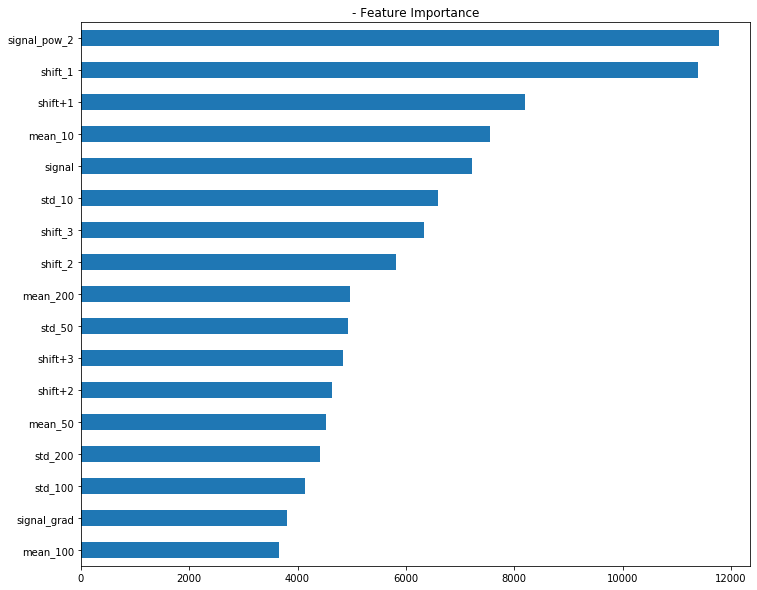

In [11]:
fi_df['importance'] = fi_df.sum(axis=1)
fi_df.sort_values('importance')['importance'][-100:].plot(
    kind='barh',
    figsize=(12, 10),
    title='- Feature Importance',
)
plt.show()

# oof: 0.93733

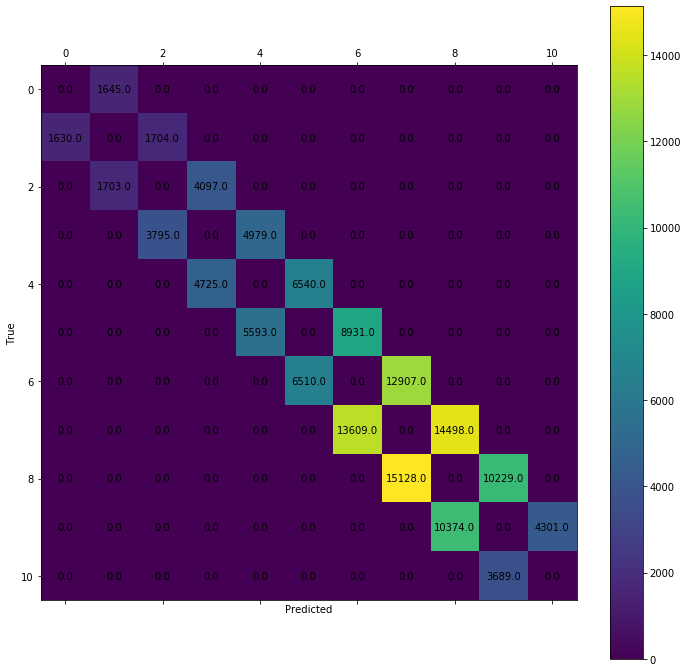

In [12]:
cm = confusion_matrix(df_train[TARGET], df_train["oof"], range(11))
cm = cm - np.eye(11) * cm
labels = range(11)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
# plt.plot(oof_pred, ".b",alpha=0.1)
# plt.plot(df_train.open_channels, ".r",alpha=0.1)

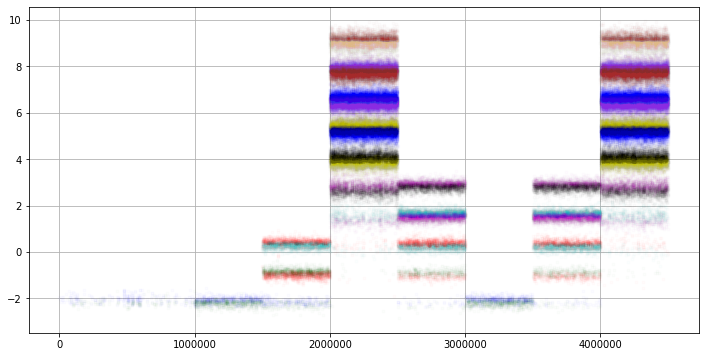

In [14]:
# oof error plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.open_channels == channel_i][df_train.oof != df_train.open_channels].signal, ".", color=color_list[channel_i], alpha=0.01)

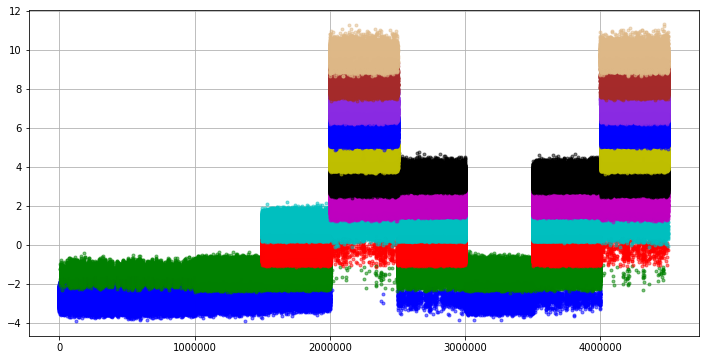

In [15]:
# oof plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.oof == channel_i].signal, ".", color=color_list[channel_i], alpha=0.5)

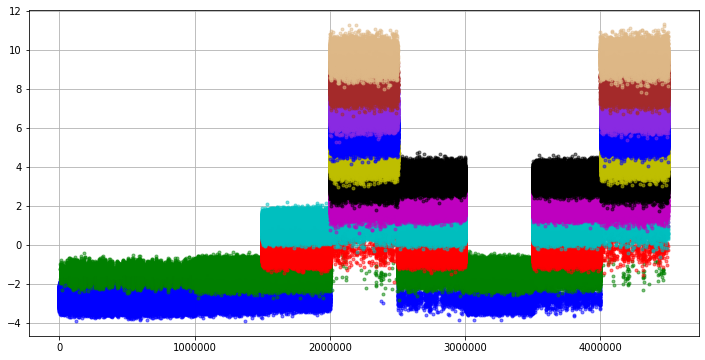

In [16]:
# train plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.open_channels == channel_i].signal, ".", color=color_list[channel_i], alpha=0.5)

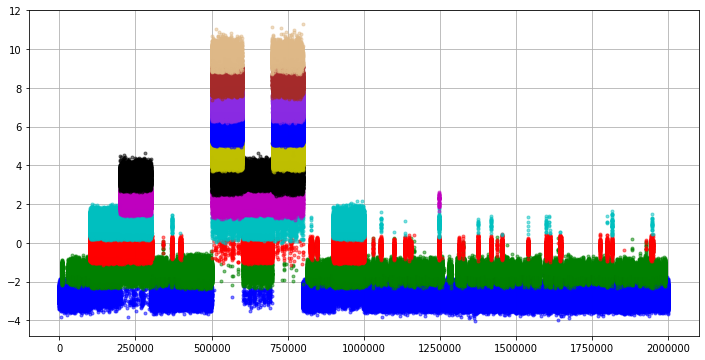

In [17]:
# test plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_test[df_test.open_channels == channel_i].signal, ".", color=color_list[channel_i], alpha=0.5)

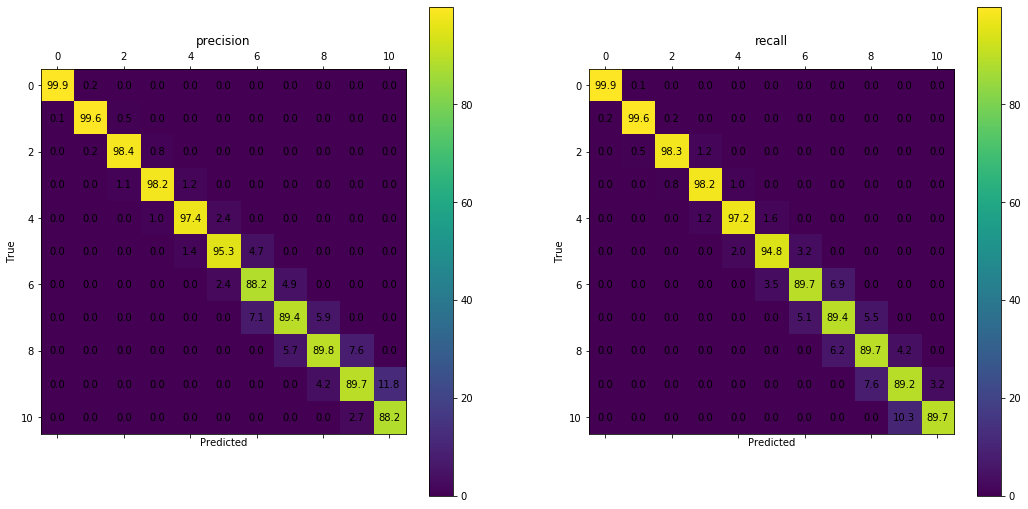

F1 score [99.9 99.6 98.3 98.2 97.3 95.  88.9 89.4 89.7 89.5 88.9]


In [18]:
class_num = 11
cm = confusion_matrix(df_train[TARGET], df_train["oof"], range(11))

# --------------------precision-------------------------
cm_precision = cm / cm.sum(axis=0).reshape([1,-1]) * 100
labels = range(class_num)
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(121)
cax = ax.matshow(cm_precision)

for (i, j), z in np.ndenumerate(cm_precision):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("precision")

# ------------------------recall---------------------
cm_recall = cm / cm.sum(axis=1).reshape([-1,1]) * 100
labels = range(class_num)
ax = fig.add_subplot(122)
cax = ax.matshow(cm_recall)

for (i, j), z in np.ndenumerate(cm_recall):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("recall")

plt.show()

cm_recall = cm / cm.sum(axis=1).reshape([-1,1])  * np.eye(cm.shape[0])
cm_precision = cm / cm.sum(axis=0).reshape([-1,1]) * np.eye(cm.shape[0])
cm = 2 *(cm_precision * cm_recall) / (cm_precision + cm_recall) * 100

print("F1 score", np.diag(cm).round(1))

In [19]:
# # look at markov 2-d oof
# for batch_i in df_train.batch.unique():
#     fig = plt.figure(figsize=(15,8))
#     for channel_i in df_train.open_channels.unique():
#         plt.plot(df_train[df_train.batch == batch_i][df_train.oof == channel_i].signal,
#                  df_train[df_train.batch == batch_i][df_train.oof == channel_i].shift_1,
#                  ".",
#                  c=color_list[channel_i],
#                  alpha=0.1)
#     plt.title("batch - " + str(batch_i))
#     plt.grid()
#     plt.show()

In [20]:
# # look at markov 2-d test
# for batch_i in df_test.batch.unique():
    
#     for mini_batch_i in df_test.mini_batch.unique():
#         fig = plt.figure(figsize=(15,8))
        
#         for channel_i in df_test.open_channels.unique():
#             plt.plot(df_test[df_test.batch == batch_i][df_test.mini_batch == mini_batch_i][df_test.open_channels == channel_i].signal,
#                      df_test[df_test.batch == batch_i][df_test.mini_batch == mini_batch_i][df_test.open_channels == channel_i].shift_1,
#                      ".",
#                      c=color_list[channel_i],
#                      alpha=0.05)
#         plt.title("batch - " + str(batch_i) + " - mini-batch " + str(mini_batch_i))
#         plt.grid()
#         plt.show()

In [21]:
# df_train_sam = df_train.sample(100)

# import eli5
# from eli5.sklearn import PermutationImportance

# # permutation importance step 1: get trained model
# model_lgb = lgb.LGBMRegressor(**param)
# model_lgb.fit(
#     df_train_sam[all_features],
#     df_train_sam[TARGET]
# )

# # run permutation importance
# perm = PermutationImportance(model_lgb,
#                              random_state=42).fit(df_train[all_features],
#                                                   df_train[TARGET],
#                                                   cv=3)

# # show feature importance weight
# eli5.show_weights(perm, feature_names = all_features, top=None)

In [22]:
# # get important features
# feature_importance = pd.DataFrame()
# feature_importance["feature_name"] = all_features
# feature_importance["feature_importance_val"] = perm.feature_importances_

# good_features = feature_importance[
#     feature_importance.feature_importance_val > 0.00].feature_name.tolist()
# print(len(good_features), "features are chosen!")
# print(good_features)

In [25]:
sub["open_channels"] = df_test.open_channels.astype("int64")
# sub.to_csv("../submissions/sub.csv", index=None)
sub.head()

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0


In [24]:
# df_train["open_channels_shift"] = df_train.open_channels.shift(1)
# df_train["diff"] = df_train["open_channels_shift"] - df_train["open_channels"] 